In [1]:
%matplotlib inline
import torch
import torch.nn as nn
from torch.nn import functional as F
from os.path import exists
import numpy as np
import time, math, sys
import matplotlib.pyplot as plt
import matplotlib.colors as colors
plt.rcParams['figure.facecolor'] = 'white'

#sys.path.insert(0, '/home/joeadamo/Research/CovA-NN-Emulator')
from CovNet import Network_Full, Network_ReverseVGG, Network_VAE, MatrixDataset, symmetric_log, symmetric_exp, VAE_loss, matrix_loss

In [2]:
# IMPORTANT: Make sure the parameters here are the same as when you trained the network in question!
N = 52500
N_test = int(N*0.1)
train_log = True
train_inverse = False
training_dir = "/home/joeadamo/Research/Data/Training-Set/"
save_dir = "/home/joeadamo/Research/CovA-NN-Emulator/Plots/"
BOSS_dir = "/home/joeadamo/Research/Data/BOSS-DR12/"
CovaPT_dir = "/home/joeadamo/Research/CovaPT/Example-Data/"

P_BOSS = np.loadtxt(BOSS_dir+"Cl-BOSS-DR12.dat")
k =np.loadtxt(CovaPT_dir+'k_Patchy.dat')
P0_mean = np.loadtxt(CovaPT_dir+'P0_fit_Patchy.dat')
P2_mean = np.loadtxt(CovaPT_dir+'P2_fit_Patchy.dat')
P4_mean = np.loadtxt(CovaPT_dir+'P4_fit_Patchy.dat')
#TODO: The k-bins between these 2 spectra aren't exactly the same, should I try interpolating?
xi_hat = np.concatenate((P_BOSS[1], P_BOSS[2]))
xi_pi = np.concatenate((P0_mean, P2_mean))
x = xi_hat - xi_pi

F_loss = nn.L1Loss()

In [3]:
# load the trained network
#net = Network_Full(6, 100*100)
net = Network_VAE()
net.load_state_dict(torch.load('network.params'))

<All keys matched successfully>

In [4]:
# load the test set
t1 = time.time()
test_data = MatrixDataset(training_dir, N_test, int(N*0.9), train_log, train_inverse)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=True)
t2 = time.time()
print("Done loading in data, took {:0.2f} s".format(t2 - t1))

Done loading in data, took 27.98 s


In [16]:
t1 = time.time()
loss_data = np.zeros(N_test)
chi_min = 1000000; chi_max = 0; chi_avg = 0.
s_min = 100000; s_max = 0; s_avg = 0.
num_bad = 0; avg_bad = 0;
for (i, batch) in enumerate(test_loader):
    params = batch[0]; matrix = batch[1]
    prediction, mu, log_var = net(matrix.view(1, 1, 100, 100))
    #loss = F_loss(prediction, matrix)
    loss = VAE_loss(prediction, matrix, mu, log_var)
    loss_data[i] = loss.item()
    perc = torch.linalg.inv(symmetric_exp(matrix.detach())); perc = perc.view(100,100).detach().numpy()
    chi_squared = np.matmul(x.T, np.matmul(perc, x))
    chi_min = min(chi_min, chi_squared); chi_max = max(chi_max, chi_squared); chi_avg += chi_squared
    prediction = prediction.view(100,100).detach().numpy()
    cov_sym = (symmetric_exp(prediction) + symmetric_exp(prediction.T))
    cov_asym = (symmetric_exp(prediction) - symmetric_exp(prediction.T))
    s_val = np.linalg.norm(cov_asym, 2) / np.linalg.norm(cov_sym, 2)
    s_min = min(s_min, s_val); s_max = max(s_max, s_val); s_avg += s_val 
    
    eigen, v = np.linalg.eig(symmetric_exp(prediction))
    if np.all(eigen > 0.) == False:
        num_bad += 1
        avg_bad += len(np.where(eigen < 0))
    
t2 = time.time()
print("Done!, took {:0.0f} minutes {:0.2f} seconds".format(math.floor((t2 - t1)/60), (t2 - t1)%60))
print("min loss: {:0.3f}, max loss {:0.3f}, avg loss: {:0.3f}".format(np.amin(loss_data), np.amax(loss_data), np.sum(loss_data) / N_test))
print("chi squared bounds: [{:0.2f}, {:0.2f}], avg = {:0.3f}".format(chi_min, chi_max, chi_avg / N_test))
print("s value bounds: [{:0.2f}, {:0.2f}], avg = {:0.3f}".format(s_min, s_max, s_avg / N_test))
if num_bad != 0:
    print(num_bad, "matrices have negative eigenvalues!, average number of negative eigenvalues =", 1.*avg_bad / num_bad)

Done!, took 9 minutes 45.36 seconds
min loss: 1900.971, max loss 12160.940, avg loss: 3217.826
chi squared bounds: [885.45, 1673.20], avg = 1272.010
s value bounds: [0.00, 0.09], avg = 0.051
5250 matrices have negative eigenvalues!, average number of negative eigenvalues = 1.0


In [9]:
# Let's do some more detailed analysis on a random matrix from the test set
idx = np.random.randint(0, N_test)
params = test_data[idx][0]
cov_actual = test_data[idx][1]
cov_predict, mu, var = net(cov_actual.view(1,1,100,100)); cov_predict = cov_predict.view(100,100)
print("loss = ", VAE_loss(cov_predict, cov_actual, mu, var).item())
#print("loss with symmetric term    = ", matrix_loss(cov_predict.view(1,100,100), cov_actual.view(1,100,100), 2).item())
#cov_predict = cov_predict.detach().numpy()
print("sample " + str(idx) + ", params:", params)

loss =  2707.739990234375
sample 3007, params: tensor([ 7.5215e+01,  3.3640e-01,  1.1994e-01,  1.4090e-09,  1.8172e+00,
        -9.2092e-01])


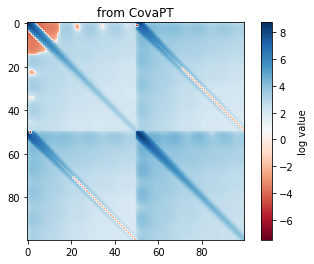

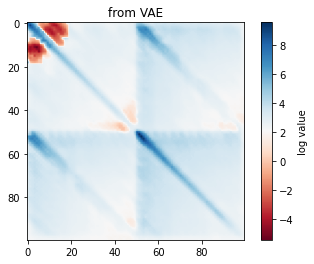

In [10]:
cov_predict = cov_predict.detach().numpy()
plt.figure()
plt.title("from CovaPT")
plt.imshow(cov_actual, cmap="RdBu")
cbar = plt.colorbar()
cbar.set_label("log value")

plt.figure()
plt.title("from VAE")
plt.imshow(cov_predict, cmap="RdBu")
cbar = plt.colorbar()
cbar.set_label("log value")

In [11]:
# Test for positive definite-ness
pos_diag = True
for i in range(cov_predict.shape[0]):
    if cov_predict[i,i] <= 0:
        pos_diag = False
print("diagonal is all positive:", pos_diag)

diagonal is all positive: True


0.0586573364246568


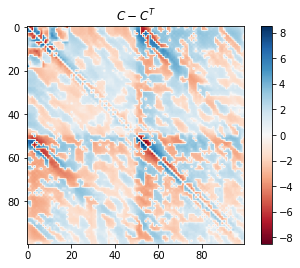

In [17]:
cov_sym = (symmetric_exp(cov_predict) + symmetric_exp(cov_predict.T))
cov_asym = (symmetric_exp(cov_predict) - symmetric_exp(cov_predict.T))
symmetric_val = np.linalg.norm(cov_asym, 2) / np.linalg.norm(cov_sym, 2)
print(symmetric_val)

plt.title(r"$C - C^T$")
plt.imshow(symmetric_log(cov_asym), cmap="RdBu")
cbar = plt.colorbar()

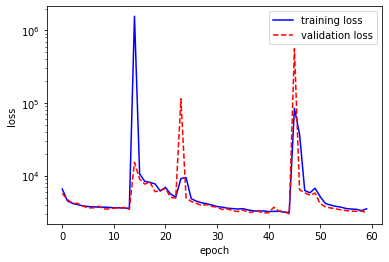

In [14]:
train_loss = torch.load("train_loss.dat")
valid_loss = torch.load("valid_loss.dat")

epoch = range(len(train_loss))
plt.plot(epoch, train_loss, color="blue", label="training loss")
plt.plot(epoch, valid_loss, color="red", ls="--", label="validation loss")
plt.xlabel("epoch")
plt.ylabel("loss")
#plt.ylim(0, 10)
plt.yscale("log")
plt.legend()

## Plots for 502 presentation

tensor([ 7.4215e+01,  3.3505e-01,  1.4554e-01,  1.8618e-09,  2.0306e+00,
        -3.7366e-01])
tensor([ 7.4502e+01,  2.7347e-01,  1.2707e-01,  1.4840e-09,  1.8555e+00,
        -5.1236e-01])


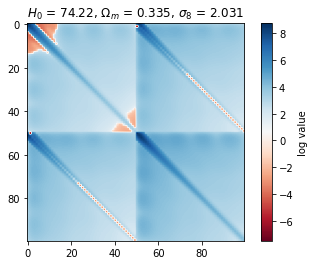

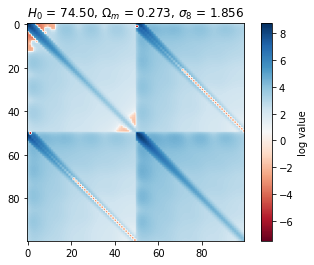

In [10]:
idx1 = np.random.randint(0, N_test)
idx2 = np.random.randint(0, N_test)

params1 = test_data[idx1][0]
params2 = test_data[idx2][0]
cov1 = test_data[idx1][1]
cov2 = test_data[idx2][1]

#H0, Omega_m, omc2, As, sigma8, b1, b2

print(params1)
print(params2)

plt.figure()
plt.title(r"$H_0$ = {:0.2f}, $\Omega_m$ = {:0.3f}, $\sigma_8$ = {:0.3f}".format(params1[0], params1[1], params1[4]))
plt.imshow(cov1, cmap="RdBu")
cbar = plt.colorbar()
cbar.set_label("log value")

plt.figure()
plt.title(r"$H_0$ = {:0.2f}, $\Omega_m$ = {:0.3f}, $\sigma_8$ = {:0.3f}".format(params2[0], params2[1], params2[4]))
plt.imshow(cov2, cmap="RdBu")
cbar = plt.colorbar()
cbar.set_label("log value")

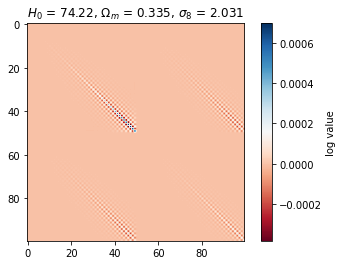

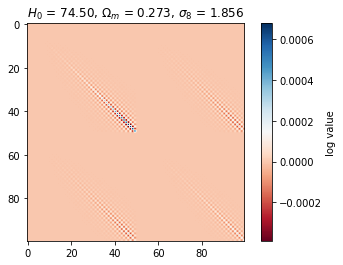

In [11]:
perc1 = torch.linalg.inv(symmetric_exp(cov1))
perc2 = torch.linalg.inv(symmetric_exp(cov2))

plt.figure()
plt.title(r"$H_0$ = {:0.2f}, $\Omega_m$ = {:0.3f}, $\sigma_8$ = {:0.3f}".format(params1[0], params1[1], params1[4]))
plt.imshow(perc1, cmap="RdBu")
cbar = plt.colorbar()
cbar.set_label("log value")

plt.figure()
plt.title(r"$H_0$ = {:0.2f}, $\Omega_m$ = {:0.3f}, $\sigma_8$ = {:0.3f}".format(params2[0], params2[1], params2[4]))
plt.imshow(perc2, cmap="RdBu")
cbar = plt.colorbar()
cbar.set_label("log value")

Chi squared 1 = tensor(1270.9537, dtype=torch.float64)
Chi squared 2 = tensor(1205.3722, dtype=torch.float64)


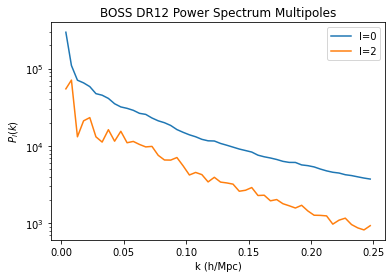

In [12]:
P_BOSS = np.loadtxt(BOSS_dir+"Cl-BOSS-DR12.dat")
k =np.loadtxt(CovaPT_dir+'k_Patchy.dat')
P0_mean = np.loadtxt(CovaPT_dir+'P0_fit_Patchy.dat')
P2_mean = np.loadtxt(CovaPT_dir+'P2_fit_Patchy.dat')
P4_mean = np.loadtxt(CovaPT_dir+'P4_fit_Patchy.dat')
#TODO: The k-bins between these 2 spectra aren't exactly the same, should I try interpolating?
xi_hat = np.concatenate((P_BOSS[1], P_BOSS[2]))
xi_pi = np.concatenate((P0_mean, P2_mean))
x = xi_hat - xi_pi

#perc1 = perc1.numpy()
#perc2 = perc2.numpy()

# We need the Hartlap factor for the patchy matrix (what about the analytic one?)
N_mocks = 2048
n_b = 50
Hartlap = (N_mocks - n_b - 2.) / (N_mocks - 1.)

# define degrees of freedom
n = len(x)*1. #currently 100 data points
# The BOSS Analytic Cov Matrix paper uses CovaPT and assumes 5 (+1 for neutrino mass) parameters, and 7? nuisance parameters
# So as an initial guess I'm going to assume there are 6 free parameters in this model
m = 6
nu = n - m

reduced_chi_squared_1 = np.matmul(x.T, np.matmul(perc1, x))# / nu
reduced_chi_squared_2 = np.matmul(x.T, np.matmul(perc2, x))# / nu

print("Chi squared 1 =", reduced_chi_squared_1)
print("Chi squared 2 =", reduced_chi_squared_2)

plt.title("BOSS DR12 Power Spectrum Multipoles")
plt.plot(k, P_BOSS[1], label="l=0")
plt.plot(k, P_BOSS[2], label="l=2")
#plt.plot(k, P4_mean, label="l=4")
plt.xlabel("k (h/Mpc)")
plt.ylabel(r"$P_l(k)$")
plt.yscale("log")
plt.legend()

In [13]:
perc_predict = torch.linalg.inv(symmetric_exp(cov_predict))
perc_actual = torch.linalg.inv(symmetric_exp(cov_actual))

reduced_chi_squared_p = np.matmul(x.T, np.matmul(perc_predict, x))# / nu
reduced_chi_squared_a = np.matmul(x.T, np.matmul(perc_actual, x))# / nu
print("Chi squared predict =", reduced_chi_squared_p)
print("Chi squared actual =", reduced_chi_squared_a)

Chi squared predict = tensor(665.1039, dtype=torch.float64)
Chi squared actual = tensor(1187.1850, dtype=torch.float64)


Text(0, 0.5, '$A_s$')

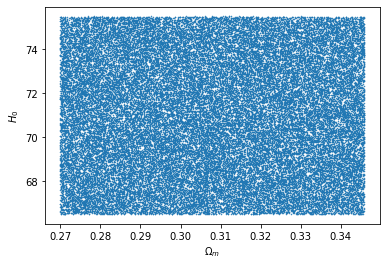

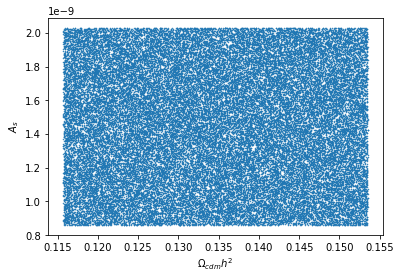

In [22]:
# Check how the parameters that we sampled are "randomly" distributed
params = np.loadtxt("Sample-params-puma.txt", skiprows=1, max_rows = 52500)
Omega_m = params[:,0]
H0 = params[:,1]
As = params[:,2]
omch2 = params[:,3]
ombh2=0.022  # Omega_b h^2 - this value is fixed
b1 = params[:,4]
b2 = params[:,5]

plt.scatter(Omega_m, H0, marker=".", s=1)
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"$H_0$")

plt.figure()
plt.scatter(omch2, As, marker=".", s=1)
plt.xlabel(r"$\Omega_{cdm} h^2$")
plt.ylabel(r"$A_s$")